In [2]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
df = pd.read_csv("C:\\Users\\rakib\\Downloads\\transactions.csv")
df.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [4]:
# Parse transaction_time to datetime
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

In [5]:
print("Missing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)
print("\nBasic Statistics for Numerical Columns:\n", df.describe())


Missing Values:
 transaction_id             0
user_id                    0
account_age_days           0
total_transactions_user    0
avg_amount_user            0
amount                     0
country                    0
bin_country                0
channel                    0
merchant_category          0
promo_used                 0
avs_match                  0
cvv_result                 0
three_ds_flag              0
transaction_time           0
shipping_distance_km       0
is_fraud                   0
dtype: int64

Data Types:
 transaction_id                           int64
user_id                                  int64
account_age_days                         int64
total_transactions_user                  int64
avg_amount_user                        float64
amount                                 float64
country                                 object
bin_country                             object
channel                                 object
merchant_category                       

In [6]:
# Validate data
current_date = pd.Timestamp(datetime(2025, 11, 12), tz='UTC')
assert all(df['transaction_time'] < current_date), "Some transactions are in the future!"
assert all(df['amount'] >= 0), "Some amounts are negative!"

df = df.sort_values(['user_id', 'transaction_time'])


In [7]:
# Temporal Features
df['hour_of_day'] = df['transaction_time'].dt.hour
df['day_of_week'] = df['transaction_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# days_since_first_transaction
df['first_txn_time'] = df.groupby('user_id')['transaction_time'].transform('min')
df['days_since_first'] = (df['transaction_time'] - df['first_txn_time']).dt.days

In [8]:
# Rolling average and std over last 7 transactions
df['rolling_avg_7'] = df.groupby('user_id')['amount'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df['rolling_std_7'] = df.groupby('user_id')['amount'].rolling(window=7, min_periods=1).std().reset_index(0, drop=True)
df['rolling_std_7'].fillna(0, inplace=True)

C:\Users\rakib\AppData\Local\Temp\ipykernel_18968\1063595780.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rolling_std_7'].fillna(0, inplace=True)


In [9]:
# Time since last transaction in hours
df['prev_txn_time'] = df.groupby('user_id')['transaction_time'].shift(1)
df['time_since_last_hours'] = (df['transaction_time'] - df['prev_txn_time']).dt.total_seconds() / 3600
df['time_since_last_hours'].fillna(0, inplace=True)

C:\Users\rakib\AppData\Local\Temp\ipykernel_18968\2346923415.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_since_last_hours'].fillna(0, inplace=True)


In [10]:
# Transaction count in last 24 hours
def count_last_24h(group):
    counts = []
    for i in range(len(group)):
        time_window_start = group.iloc[i]['transaction_time'] - pd.Timedelta(hours=24)
        count = ((group['transaction_time'] > time_window_start) & 
                 (group['transaction_time'] < group.iloc[i]['transaction_time'])).sum()
        counts.append(count)
    return pd.Series(counts, index=group.index)

df['txn_count_24h'] = df.groupby('user_id').apply(count_last_24h).reset_index(level=0, drop=True)

C:\Users\rakib\AppData\Local\Temp\ipykernel_18968\669347245.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['txn_count_24h'] = df.groupby('user_id').apply(count_last_24h).reset_index(level=0, drop=True)


In [11]:
# Risk Flags
df['bin_country_mismatch'] = (df['country'] != df['bin_country']).astype(int)
high_risk_countries = ['RO', 'DE', 'ES', 'TR']  # Mock list based on sample data
df['high_risk_country'] = df['bin_country'].isin(high_risk_countries).astype(int)
df['security_failure'] = ((df['avs_match'] == 0) & (df['cvv_result'] == 0)).astype(int)

In [12]:
# Drop temporary columns
df = df.drop(['first_txn_time', 'prev_txn_time'], axis=1)

# Time-based split (assuming all data in 2024)
df['month'] = df['transaction_time'].dt.month
train = df[(df['month'] >= 1) & (df['month'] <= 6)].copy()
val = df[(df['month'] >= 7) & (df['month'] <= 8)].copy()
test = df[(df['month'] >= 9) & (df['month'] <= 10)].copy()

In [13]:
# Drop transaction_time and month as no longer needed
train.drop(['transaction_time', 'month'], axis=1, inplace=True)
val.drop(['transaction_time', 'month'], axis=1, inplace=True)
test.drop(['transaction_time', 'month'], axis=1, inplace=True)

# Step 3: Transform - Data Encoding & Scaling
categorical_cols = ['country', 'bin_country', 'channel', 'merchant_category']
numerical_cols = ['account_age_days', 'total_transactions_user', 'avg_amount_user', 'amount', 
                  'shipping_distance_km', 'rolling_avg_7', 'rolling_std_7', 
                  'time_since_last_hours', 'txn_count_24h', 'days_since_first']

In [14]:
# One-Hot Encoding (fit on train)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(train[categorical_cols])

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [15]:
# Transform train
train_encoded = pd.DataFrame(ohe.transform(train[categorical_cols]), 
                             columns=ohe.get_feature_names_out(), index=train.index)
train = pd.concat([train.drop(categorical_cols, axis=1), train_encoded], axis=1)

In [16]:
# Transform val
val_encoded = pd.DataFrame(ohe.transform(val[categorical_cols]), 
                           columns=ohe.get_feature_names_out(), index=val.index)
val = pd.concat([val.drop(categorical_cols, axis=1), val_encoded], axis=1)

# Transform test
test_encoded = pd.DataFrame(ohe.transform(test[categorical_cols]), 
                            columns=ohe.get_feature_names_out(), index=test.index)
test = pd.concat([test.drop(categorical_cols, axis=1), test_encoded], axis=1)

In [17]:
# Scaling (fit on train)
scaler = StandardScaler()
scaler.fit(train[numerical_cols])

train[numerical_cols] = scaler.transform(train[numerical_cols])
val[numerical_cols] = scaler.transform(val[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

In [18]:
train.to_csv('train_processed.csv', index=False)
val.to_csv('val_processed.csv', index=False)
test.to_csv('test_processed.csv', index=False)

print("Processed datasets saved successfully!")

Processed datasets saved successfully!


# **Apply ML**

In [19]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, fbeta_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [20]:
train = pd.read_csv('train_processed.csv')
val = pd.read_csv('val_processed.csv')
test = pd.read_csv('test_processed.csv')

In [21]:
# Separate features and target
target = 'is_fraud'
X_train = train.drop(columns=[target])
y_train = train[target]
X_val = val.drop(columns=[target])
y_val = val[target]
X_test = test.drop(columns=[target])
y_test = test[target]

In [22]:
# Address class imbalance with SMOTE (on train only)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [23]:
# Define models and hyperparameter grids
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}

xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

In [24]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tune Random Forest
rf_grid = GridSearchCV(rf, rf_param_grid, cv=cv, scoring='average_precision', n_jobs=-1)
rf_grid.fit(X_train_resampled, y_train_resampled)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'n_estimators': [50, 100]}"
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [25]:
# Tune XGBoost
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=cv, scoring='average_precision', n_jobs=-1)
xgb_grid.fit(X_train_resampled, y_train_resampled)

# Get best models
best_rf = rf_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

C:\Users\rakib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [26]:
# Evaluate on validation set to select best model
models = {'Random Forest': best_rf, 'XGBoost': best_xgb}
best_model_name = None
best_ap = 0

for name, model in models.items():
    y_prob_val = model.predict_proba(X_val)[:, 1]
    ap_val = average_precision_score(y_val, y_prob_val)
    print(f"{name} - Validation Average Precision: {ap_val:.4f}")
    if ap_val > best_ap:
        best_ap = ap_val
        best_model_name = name

print(f"Best model on validation: {best_model_name}")

Random Forest - Validation Average Precision: 0.8290
XGBoost - Validation Average Precision: 0.8723
Best model on validation: XGBoost


In [27]:
# Final evaluation on test set with best model
best_model = models[best_model_name]
y_pred_test = best_model.predict(X_test)
y_prob_test = best_model.predict_proba(X_test)[:, 1]

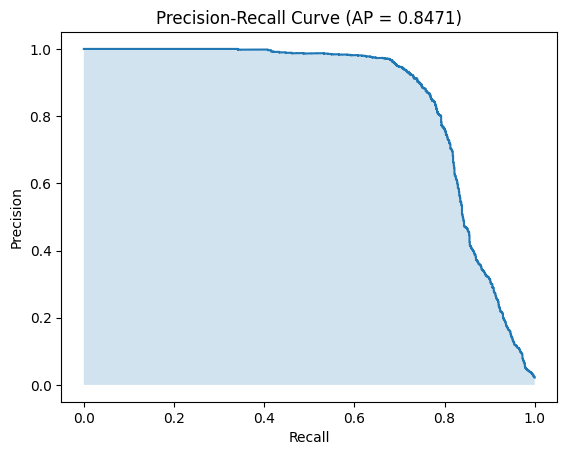

In [28]:
# Precision-Recall Curve and AP
ap_test = average_precision_score(y_test, y_prob_test)
precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
plt.figure()
plt.step(recall, precision, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap_test:.4f})')
plt.show()

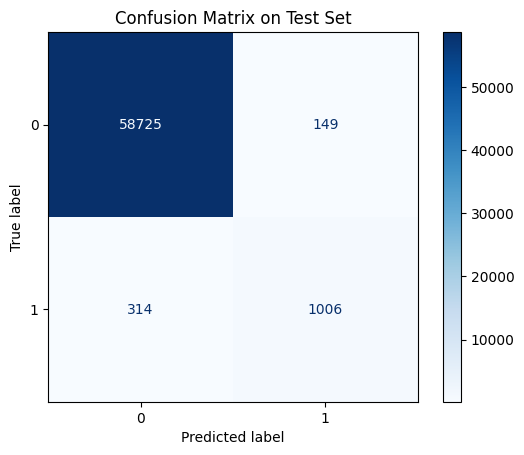

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()


In [30]:
# F2-Score
f2 = fbeta_score(y_test, y_pred_test, beta=2)
print(f"F2-Score on Test Set: {f2:.4f}")

F2-Score on Test Set: 0.7817


In [31]:
# Extract feature importances (assuming tree-based model)
importances = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

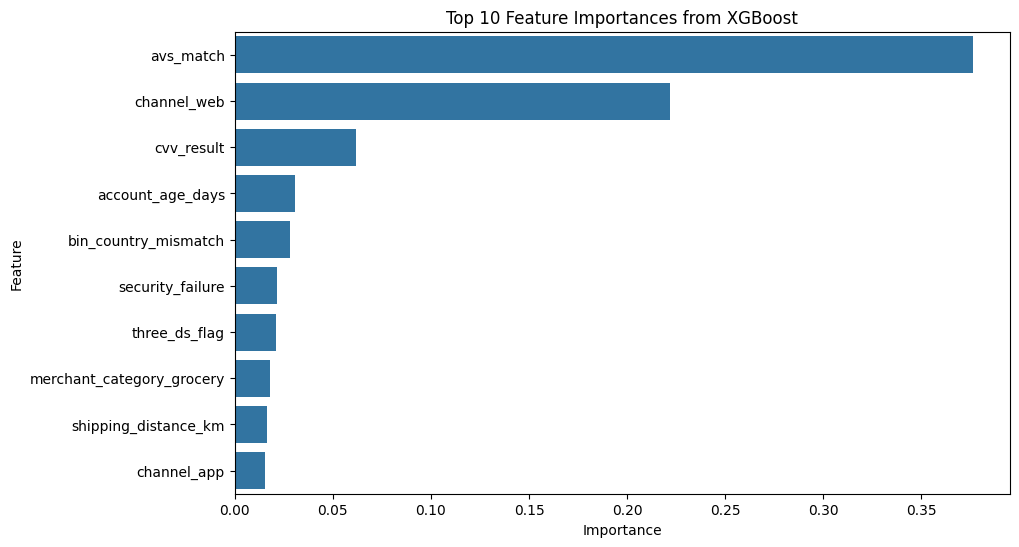

In [32]:
# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title(f'Top 10 Feature Importances from {best_model_name}')
plt.show()

In [33]:
# Top 5 features
top_5 = feature_importance_df.head(5)['Feature'].tolist()
print("Top 5 Features Driving Fraud Predictions:")
for i, feature in enumerate(top_5, 1):
    print(f"{i}. {feature}")

Top 5 Features Driving Fraud Predictions:
1. avs_match
2. channel_web
3. cvv_result
4. account_age_days
5. bin_country_mismatch


# **Deep Learning**

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import average_precision_score, fbeta_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')

C:\Users\rakib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Step 1: Data Preprocessing for DL
# Load processed datasets
train = pd.read_csv('train_processed.csv')
val = pd.read_csv('val_processed.csv')
test = pd.read_csv('test_processed.csv')

# Separate features and target
target = 'is_fraud'
X_train = train.drop(columns=[target])
y_train = train[target].values
X_val = val.drop(columns=[target])
y_val = val[target].values
X_test = test.drop(columns=[target])
y_test = test[target].values

In [36]:
# Create mapping from one-hot columns back to original categories
def reverse_onehot(df, prefix):
    cols = [c for c in df.columns if c.startswith(prefix + '_')]
    if not cols:
        return pd.Series([None] * len(df), index=df.index)
    return df[cols].idxmax(axis=1).str.replace(prefix + '_', '')

In [37]:
# Extract original categorical values using one-hot columns
X_train_cat = pd.DataFrame()
X_val_cat = pd.DataFrame()
X_test_cat = pd.DataFrame()

for col in categorical_cols:
    X_train_cat[col] = reverse_onehot(X_train, col)
    X_val_cat[col] = reverse_onehot(X_val, col)
    X_test_cat[col] = reverse_onehot(X_test, col)

In [38]:
# Drop one-hot columns from numerical part
onehot_cols = [c for c in X_train.columns if any(c.startswith(prefix + '_') for prefix in categorical_cols)]
X_train_num = X_train.drop(columns=onehot_cols + [target] if target in X_train.columns else onehot_cols)
X_val_num = X_val.drop(columns=onehot_cols + [target] if target in X_val.columns else onehot_cols)
X_test_num = X_test.drop(columns=onehot_cols + [target] if target in X_test.columns else onehot_cols)

In [39]:
# Scale numerical features (fit on train)
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [40]:
# Create embedding input: map categories to integers
embedding_inputs = {}
vocab_sizes = {}
for col in categorical_cols:
    # Fit label encoder
    unique_vals = pd.concat([X_train_cat[col], X_val_cat[col], X_test_cat[col]], axis=0).unique()
    mapping = {val: idx + 1 for idx, val in enumerate(unique_vals)}  # +1 to reserve 0 for padding/missing
    vocab_sizes[col] = len(mapping) + 1

    X_train_cat[col] = X_train_cat[col].map(mapping).fillna(0).astype(int)
    X_val_cat[col] = X_val_cat[col].map(mapping).fillna(0).astype(int)
    X_test_cat[col] = X_test_cat[col].map(mapping).fillna(0).astype(int)

In [41]:
# Convert to numpy arrays
cat_train = [X_train_cat[col].values for col in categorical_cols]
cat_val = [X_val_cat[col].values for col in categorical_cols]
cat_test = [X_test_cat[col].values for col in categorical_cols]

In [42]:
# Drop one-hot columns from numerical part
onehot_cols = [c for c in X_train.columns if any(c.startswith(prefix + '_') for prefix in categorical_cols)]
X_train_num = X_train.drop(columns=onehot_cols + [target] if target in X_train.columns else onehot_cols)
X_val_num = X_val.drop(columns=onehot_cols + [target] if target in X_val.columns else onehot_cols)
X_test_num = X_test.drop(columns=onehot_cols + [target] if target in X_test.columns else onehot_cols)

In [43]:
# Scale numerical features (fit on train)
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [44]:
# Create embedding input: map categories to integers
embedding_inputs = {}
vocab_sizes = {}
for col in categorical_cols:
    # Fit label encoder
    unique_vals = pd.concat([X_train_cat[col], X_val_cat[col], X_test_cat[col]], axis=0).unique()
    mapping = {val: idx + 1 for idx, val in enumerate(unique_vals)}  # +1 to reserve 0 for padding/missing
    vocab_sizes[col] = len(mapping) + 1

    X_train_cat[col] = X_train_cat[col].map(mapping).fillna(0).astype(int)
    X_val_cat[col] = X_val_cat[col].map(mapping).fillna(0).astype(int)
    X_test_cat[col] = X_test_cat[col].map(mapping).fillna(0).astype(int)

In [45]:
#Model Architecture Design
def build_dl_model():
    # Input layers
    num_input = layers.Input(shape=(X_train_num_scaled.shape[1],), name='numerical')
    cat_inputs = [layers.Input(shape=(1,), name=f'cat_{col}') for col in categorical_cols]

    # Embedding layers (embedding dim = min(50, vocab_size//2))
    embeddings = []
    for i, col in enumerate(categorical_cols):
        vocab = vocab_sizes[col]
        embed_dim = min(50, max(2, vocab // 2))
        embed = layers.Embedding(input_dim=vocab, output_dim=embed_dim, name=f'embed_{col}')(cat_inputs[i])
        embed = layers.Flatten()(embed)
        embeddings.append(embed)

    # Numerical branch
    num_branch = layers.Dense(128, activation='relu')(num_input)
    num_branch = layers.Dropout(0.3)(num_branch)
    num_branch = layers.Dense(64, activation='relu')(num_branch)
    num_branch = layers.Dropout(0.3)(num_branch)

    # Concatenate all
    concat = layers.Concatenate()([num_branch] + embeddings)
    x = layers.Dense(128, activation='relu')(concat)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=[num_input] + cat_inputs, outputs=output)
    return model

model = build_dl_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [46]:
# Compute class weights
neg, pos = np.bincount(y_train)
total = neg + pos
weight_for_0 = (1 / neg) * (total) / 2.0
weight_for_1 = (1 / pos) * (total) / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Class weights: {{0: {weight_for_0:.2f}, 1: {weight_for_1:.2f}}}")

# Early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

Class weights: {0: 0.51, 1: 22.40}


In [47]:
# Train
history = model.fit(
    x=[X_train_num_scaled] + cat_train,
    y=y_train,
    validation_data=([X_val_num_scaled] + cat_val, y_val),
    epochs=100,
    batch_size=128,
    class_weight=class_weight,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - AUC: 0.9267 - loss: 0.3426 - val_AUC: 0.9513 - val_loss: 0.2070
Epoch 2/100
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - AUC: 0.9419 - loss: 0.3029 - val_AUC: 0.9535 - val_loss: 0.2291
Epoch 3/100
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.9450 - loss: 0.2947 - val_AUC: 0.9556 - val_loss: 0.2252
Epoch 4/100
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.9476 - loss: 0.2868 - val_AUC: 0.9581 - val_loss: 0.1930
Epoch 5/100
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.9511 - loss: 0.2795 - val_AUC: 0.9595 - val_loss: 0.1971
Epoch 6/100
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.9514 - loss: 0.2779 - val_AUC: 0.9599 - val_loss: 0.1981
Epoch 7/100
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.9535 - loss: 0.2706 - val_AUC: 0.9619 - val_loss: 0.1907
Epoch 8/100
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.9557 - loss: 0.2640 - val_AUC: 0.9618 - val_loss: 0.2075
Epoch 9/100
1398/1398 ━━━━━━━━

In [48]:
# Predict on test
y_prob_dl = model.predict([X_test_num_scaled] + cat_test).flatten()
y_pred_dl = (y_prob_dl > 0.5).astype(int)

# Average Precision
ap_dl = average_precision_score(y_test, y_prob_dl)
print(f"Deep Learning - Test Average Precision: {ap_dl:.4f}")

# F2-Score
f2_dl = fbeta_score(y_test, y_pred_dl, beta=2)
print(f"Deep Learning - Test F2-Score: {f2_dl:.4f}")

1882/1882 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Deep Learning - Test Average Precision: 0.7365
Deep Learning - Test F2-Score: 0.6718


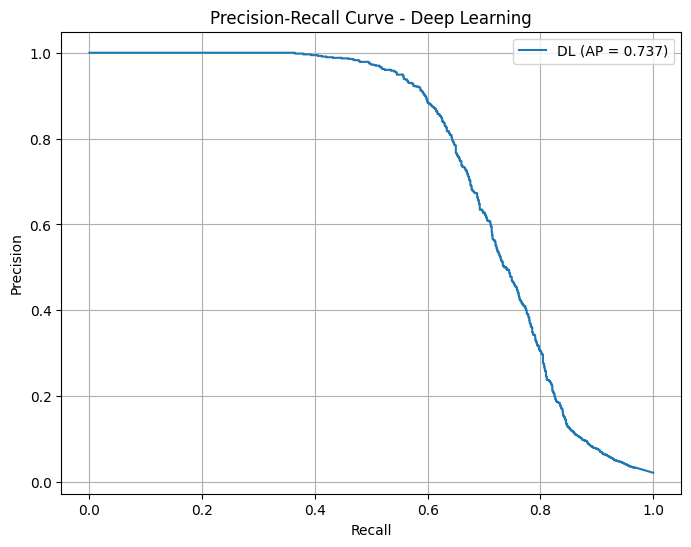


MODEL PERFORMANCE COMPARISON
Model                AP Score     F2 Score  
------------------------------------------------------------
Best ML Model        0.8723          0.7817
Deep Learning        0.7365          0.6718
------------------------------------------------------------


In [49]:
# Precision-Recall Curve
precision_dl, recall_dl, _ = precision_recall_curve(y_test, y_prob_dl)
plt.figure(figsize=(8, 6))
plt.plot(recall_dl, precision_dl, label=f'DL (AP = {ap_dl:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Deep Learning')
plt.legend()
plt.grid(True)
plt.show()

# Compare with best ML model (from previous question)
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(f"{'Model':<20} {'AP Score':<12} {'F2 Score':<10}")
print("-"*60)
print(f"{'Best ML Model':<20} {best_ap:.4f} {' '*8} {f2:.4f}")
print(f"{'Deep Learning':<20} {ap_dl:.4f} {' '*8} {f2_dl:.4f}")
print("-"*60)

# **Advanced Analysis & Strategy**

In [50]:
# Using Deep Learning model
y_prob = model.predict([X_test_num_scaled] + cat_test).flatten()
y_true = y_test
amounts = test['amount'].values

# Ensure alignment
assert len(y_true) == len(y_prob) == len(amounts), "Mismatch in lengths!"

1882/1882 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [51]:
COST_FP = 10.0
thresholds = np.linspace(0.01, 0.99, 100)
total_costs = []
fp_counts = []
fn_costs = []
tp_counts = []
fp_rates = []
recall_scores = []

for thresh in thresholds:
    y_pred = (y_prob >= thresh).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # FP Cost: fixed per false positive
    cost_fp = fp * COST_FP
    
    # FN Cost: sum of transaction amounts for all missed frauds
    fn_mask = (y_pred == 0) & (y_true == 1)
    cost_fn = amounts[fn_mask].sum()
    
    total_cost = cost_fp + cost_fn
    
    total_costs.append(total_cost)
    fp_counts.append(fp)
    fn_costs.append(cost_fn)
    tp_counts.append(tp)
    fp_rates.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
    recall_scores.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

In [52]:
# Convert to arrays
total_costs = np.array(total_costs)
fp_counts = np.array(fp_counts)
fn_costs = np.array(fn_costs)

# Step 4: Find Optimal Threshold
# --------------------------------
optimal_idx = np.argmin(total_costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = total_costs[optimal_idx]

# Cost at default threshold (0.5)
default_idx = np.argmin(np.abs(thresholds - 0.5))
cost_at_05 = total_costs[default_idx]

cost_savings = cost_at_05 - min_cost
cost_savings_pct = (cost_savings / cost_at_05) * 100 if cost_at_05 > 0 else 0

print("="*70)
print("FRAUD DETECTION THRESHOLD OPTIMIZATION RESULTS")
print("="*70)
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Minimum Total Cost: ${min_cost:,.2f}")
print(f"Cost at Threshold 0.5: ${cost_at_05:,.2f}")
print(f"Estimated Cost Savings: ${cost_savings:,.2f} ({cost_savings_pct:.1f}%)")
print("-"*70)

FRAUD DETECTION THRESHOLD OPTIMIZATION RESULTS
Optimal Threshold: 0.990
Minimum Total Cost: $71.14
Cost at Threshold 0.5: $10,734.12
Estimated Cost Savings: $10,662.99 (99.3%)
----------------------------------------------------------------------


In [53]:
# Extract metrics at optimal threshold
y_pred_opt = (y_prob >= optimal_threshold).astype(int)
tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(y_true, y_pred_opt).ravel()
fn_mask_opt = (y_pred_opt == 0) & (y_true == 1)
fraud_loss_saved = amounts[(y_pred_opt == 1) & (y_true == 1)].sum()
fraud_loss_missed = amounts[fn_mask_opt].sum()

print(f"At Optimal Threshold ({optimal_threshold:.3f}):")
print(f"  True Positives (Fraud Caught): {tp_opt} → Saved: ${fraud_loss_saved:,.2f}")
print(f"  False Negatives (Fraud Missed): {fn_opt} → Lost: ${fraud_loss_missed:,.2f}")
print(f"  False Positives (Good Blocked): {fp_opt} → Cost: ${fp_opt * COST_FP:,.2f}")
print(f"  False Positive Rate: {fp_rates[optimal_idx]:.3%}")
print(f"  Recall (Fraud Detection Rate): {recall_scores[optimal_idx]:.3%}")

At Optimal Threshold (0.990):
  True Positives (Fraud Caught): 506 → Saved: $1,691.99
  False Negatives (Fraud Missed): 814 → Lost: $51.14
  False Positives (Good Blocked): 2 → Cost: $20.00
  False Positive Rate: 0.003%
  Recall (Fraud Detection Rate): 38.333%


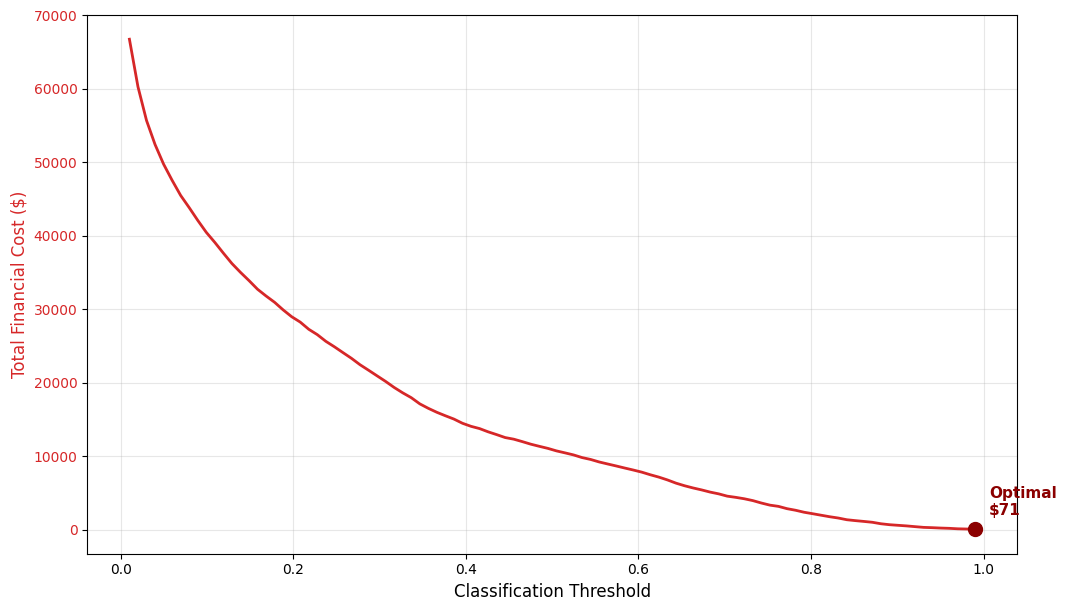

In [54]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot total cost
color = 'tab:red'
ax1.set_xlabel('Classification Threshold', fontsize=12)
ax1.set_ylabel('Total Financial Cost ($)', color=color, fontsize=12)
ax1.plot(thresholds, total_costs, color=color, linewidth=2, label='Total Cost')
ax1.scatter(optimal_threshold, min_cost, color='darkred', s=100, zorder=5)
ax1.annotate(f'Optimal\n${min_cost:,.0f}', 
             (optimal_threshold, min_cost), 
             xytext=(10, 10), textcoords='offset points',
             fontsize=11, color='darkred', weight='bold')

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

In [55]:
print("\n" + "="*70)
print("ACTIONABLE BUSINESS RECOMMENDATION")
print("="*70)
print(f"By lowering the fraud detection threshold from 0.5 to {optimal_threshold:.2f},")
print(f"we reduce total monthly financial loss by an estimated {cost_savings_pct:.1f}%")
print(f"(${cost_savings:,.0f}), while accepting a modest increase in false positives.")
print("\nKey Trade-off:")
print(f"• Catch {tp_opt - ((y_prob >= 0.5) & (y_true == 1)).sum()} more fraud cases")
print(f"• Block {fp_opt - ((y_prob >= 0.5) & (y_true == 0)).sum()} additional legitimate transactions")
print(f"• Net financial gain: ${(fraud_loss_saved - fraud_loss_missed) - (fp_opt * COST_FP):,.0f}")
print("\nRecommendation:")
print("→ Implement dynamic thresholding in production.")
print("→ Use amount-based rules: apply lower threshold only to high-value transactions.")
print("→ Monitor FP rate weekly and adjust COST_FP if customer complaints rise.")
print("→ A/B test the new threshold on 10% of traffic before full rollout.")



ACTIONABLE BUSINESS RECOMMENDATION
By lowering the fraud detection threshold from 0.5 to 0.99,
we reduce total monthly financial loss by an estimated 99.3%
($10,663), while accepting a modest increase in false positives.

Key Trade-off:
• Catch -483 more fraud cases
• Block -1090 additional legitimate transactions
• Net financial gain: $1,621

Recommendation:
→ Implement dynamic thresholding in production.
→ Use amount-based rules: apply lower threshold only to high-value transactions.
→ Monitor FP rate weekly and adjust COST_FP if customer complaints rise.
→ A/B test the new threshold on 10% of traffic before full rollout.


In [56]:
results_df = pd.DataFrame({
    'threshold': thresholds,
    'total_cost': total_costs,
    'fp_cost': fp_counts * COST_FP,
    'fn_cost': fn_costs,
    'fp_count': fp_counts,
    'recall': recall_scores,
    'fp_rate': fp_rates
})
results_df.to_csv('threshold_optimization_results.csv', index=False)
print(f"\nThreshold analysis exported to 'threshold_optimization_results.csv'")


Threshold analysis exported to 'threshold_optimization_results.csv'


In [57]:
# Sensitivity Analysis over COST_FP
cost_fp_values = [5, 10, 20, 50]  # Vary false positive cost
thresholds = np.linspace(0.01, 0.99, 100)

results = []

print("\nRunning sensitivity analysis over COST_FP values...")
for COST_FP in cost_fp_values:
    print(f"  Analyzing COST_FP = ${COST_FP}...")
    total_costs = []
    
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        # FP cost
        cost_fp = fp * COST_FP
        
        # FN cost: sum of fraud amounts missed
        fn_mask = (y_pred == 0) & (y_test == 1)
        cost_fn = amounts[fn_mask].sum()
        
        total_cost = cost_fp + cost_fn
        total_costs.append(total_cost)
    
    total_costs = np.array(total_costs)
    optimal_idx = np.argmin(total_costs)
    optimal_thresh = thresholds[optimal_idx]
    min_cost = total_costs[optimal_idx]
    
    # At threshold 0.5
    idx_05 = np.argmin(np.abs(thresholds - 0.5))
    cost_at_05 = total_costs[idx_05]
    savings_pct = ((cost_at_05 - min_cost) / cost_at_05) * 100 if cost_at_05 > 0 else 0
    
    results.append({
        'COST_FP': COST_FP,
        'Optimal_Threshold': round(optimal_thresh, 3),
        'Min_Cost': round(min_cost, 2),
        'Cost_at_0.5': round(cost_at_05, 2),
        'Savings_%': round(savings_pct, 1)
    })


Running sensitivity analysis over COST_FP values...
  Analyzing COST_FP = $5...
  Analyzing COST_FP = $10...
  Analyzing COST_FP = $20...
  Analyzing COST_FP = $50...
